### Census Data

Consider the following questions: 
- Who is my customer? 
- Where should I relocate my plant or head quarters? 
- Where would be a good location for a new store (given my knowledge of my customer)? 

**How would you answer these questions?** This lecture will talk through one approach: Get detailed demographic information about the people that live in a given area, then use that information to answer the questions above. How do you get detailed demographic information? Well the US census!

What is the US census? Every 10 years the US government is required to essentially count all people within the United States and in doing so detailed information is constructed. A new innovation that is of interest to us is the American Community Survey. This is a Survey (not a census), but is matched up with the 10 year census in a way to provide detailed demographic information at a **yearly** frequency. So you can find out median household income in zip code 90210 for 2015, 2014, etc. actually only going back to 2010 since this is a new development.

A second development is that the US census has a well developed API for which we can directly access the data. In the past, this process would look like this: bulk download `.csv` files, pull what you need, store it, etc. Now on the fly you can get what you want directly (and I think the main user of this are commercial vendors, e.g. like you look at Zillow and some characteristics of that zip code are reported, this is a direct feed from the census). 

**What are we going to do with it?** We will learn how to use the Census API and then use information to ask who voted for Trump or Clinton in the 2016 Presidential election. This is a nice application because, we know election results at very fine levels of geography, but we will never know individual votes. But we can `merge` the election results up with demographic information at those fine geographic locations and be able to make statements like "areas with a less educated population were more likely to vote for candidate X" Along the way, we will learn some more stuff:
- Census API
- More practice `merge`ing
- Pivot Tables

Then this will fit with the next two lectures:
- Statistics in python `statsmodels.api`
- Mapping 

#### Getting Started

So below are the packages that we need. The first two we know. The `Census` package is the new one:

In [63]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

from census import Census # This is new...
from us import states

Now before we can use this, YOU need to get access. It is very easy, just go here:

https://api.census.gov/data/key_signup.html

And then follow the instructions. This will give you a personalized key that you can use when interfacing with the Census. If you are having trouble, just use my key.

One you have a key, you create a session. The syntax looks like this:

In [3]:
my_api_key = '34e40301bda77077e24c859c6c6c0b721ad73fc7'
# This is my api_key

c = Census(my_api_key)
# This will create an object c which has methods associated with it.
# We will see  these below.


#type(c)

Now below is the basic syntax. Here are [some examples](https://pypi.python.org/pypi/census). The quick start is you do `c.acs5.get (stuff)`. 

- The first bit `acs5` says use the 5 year America Community Survey. There are other options, but this will give data at the finest geographical level possible. As I update this lecture, I explain some more differences. 
- The next git `get` says get the data
- Then the stuff in the brackets tells it what to grab. There are essentially three elements: the first one `code` tells it the code associated with the data series you want, (if you want multiple sereis, create a tuple); the second element describes the geography, the third element is the year.

Lets do an example:

In [4]:
code = ("NAME","B01001_001E") # This says grab the geographical name, and  B01001_001E 
                               # is the population. 
    
state_pop_2015 = c.acs5.get(code, {'for': 'state:'+ states.CA.fips }, year=2015)
                                  # Then this element says for 
                                  # Then the next element says, by state, then the specific state
                                  # you are looking for. Here is the trick, states are classified by FIPS numbers
                                  # So you then use the state.CA.fips which generates the correct
                                  # FIPS value for California.

state_pop_2015 = pd.DataFrame(state_pop_2015)


state_pop_2015.head()

#county_2015[code].astype(float).sum()


,B01001_001E,NAME,state
0,38421464,California,06


Lets do one more example: Here is population and total foreign born population in that state.

In [5]:
code = ("NAME","B01001_001E","B05006_001E") # This says grab the geographical name, and  B01001_001E 
                               # is the population; B05006_001E is foreign born population (i.e. immigrants)
    
state_pop_2015 = c.acs5.get(code, {'for': 'state:'+ states.CA.fips }, year=2015)
                                  # Then this element says for 
                                  # Then the next element says, by state, then the specific state
                                  # you are looking for. Here is the trick, states are classified by FIPS numbers
                                  # So you then use the state.CA.fips which generates the correct
                                  # FIPS value for California.

state_pop_2015 = pd.DataFrame(state_pop_2015)


state_pop_2015.head()

#county_2015[code].astype(float).sum()


,B01001_001E,B05006_001E,NAME,state
0,38421464,10389990,California,06


Almost a 1/4 of the population in California is foreign born! Is this correct? Quick check and google this and see the answer that you get. 

**How do I get information for all the states?** The simple answer is to use `*` which is the [wild card character](https://en.wikipedia.org/wiki/Wildcard_character) for their data: So you just do this:

In [6]:
code = ("NAME","B01001_001E","B05006_001E") # This says grab the geographical name, and  B01001_001E 
                               # is the population; B05006_001E is foreign born population (i.e. immigrants)
    
state_pop_2015 = c.acs5.get(code, {'for': 'state:* '}, year=2015)
                                  # Everythig is the same now... but the * says take all states

state_pop_2015 = pd.DataFrame(state_pop_2015)

print(state_pop_2015.shape)

state_pop_2015.head()

#county_2015[code].astype(float).sum()

(52, 4)


,B01001_001E,B05006_001E,NAME,state
0,733375,54047,Alaska,02
1,4830620,167224,Alabama,01
2,2958208,138822,Arkansas,05
3,6641928,896004,Arizona,04
4,38421464,10389990,California,06


Some quick exercises:

- **What is the population of the United States?**
- **What is the foreign born population of the United states?**

In [7]:
numeric_code = ["B01001_001E","B05006_001E"]

state_pop_2015[numeric_code].astype(float).sum()

total_population = state_pop_2015[numeric_code].astype(float).sum()


Does this make sense? Again, google it!

#### Finer Levels of Geography

The state stuff is interesting, but what is really cool is that very detailed levels of geography can be found. Two that may be of interest are:
- Counties: We should have a sense of what these are. 
- Zip Code Tabulation Areas: This is close to a zip code. In some instances it is not because of census protacols. 

Lets check it out....

In [8]:
code = ("NAME","B01001_001E","B05006_001E") # Same Codes:

county_2015 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': 'county:*'}, year=2015))
                                         # Same deal, but we specify county then the wild card
                                         # On the example page, there are ways do do this, only by state
county_2015.head()

# HEre is another way to look at only one state...
        
county_2015[county_2015["NAME"].str.contains("Alaska")]

,B01001_001E,B05006_001E,NAME,county,state
67,3304,1491,"Aleutians East Borough, Alaska",013,02
68,5684,2012,"Aleutians West Census Area, Alaska",016,02
69,299107,29803,"Anchorage Municipality, Alaska",020,02
70,17776,328,"Bethel Census Area, Alaska",050,02
71,970,19,"Bristol Bay Borough, Alaska",060,02
72,2060,139,"Denali Borough, Alaska",068,02
73,4979,83,"Dillingham Census Area, Alaska",070,02
74,99705,5067,"Fairbanks North Star Borough, Alaska",090,02
75,2560,181,"Haines Borough, Alaska",100,02
76,2128,114,"Hoonah-Angoon Census Area, Alaska",105,02


In [9]:
code = ("NAME","B19013_001E", "B01001_001E") 
# The new code I added was median houshold income:
    
zip_2015 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': 'zip code tabulation area: 90210, 90059'}, year=2014))

zip_2015.head()

,B01001_001E,B19013_001E,NAME,zip code tabulation area
0,42470,33678,ZCTA5 90059,90059
1,21478,138750,ZCTA5 90210,90210


This is interesting. We all know the zip code 90210, the zip code 90059 is also in the Los Angeles area, it happens to be part of the "Compton" neighborhood. Google it if you don't know what that it. Median income in Beverly Hills is about 138 thousand dollars, Compton is about 34 thousand. If you were selling designer handbags, where do you want to locate? If you owned a "dollar store" where would be a good location? 

### Who voted for Trump? For Clinton?

The idea here is to `merge` some demographic characteristics with election results. Here is my mapping out of the approach:
- Lets look at the election data (determine the appropriate geography for the Census data)
- Pull the Census data
- `Merge` it
- Learn about `pivot` tables to report some simple "cuts" of the data before we get to a more formal statistical analysis next lecture.

** Election Data: Below is a link to some election data...***

In [10]:
url = "https://raw.githubusercontent.com/mwaugh0328/Did-China-Cause-Trump/master/us-election-2016-results-by-county.csv"

election_2016 = pd.read_csv(url)

election_2016.head()

,StateCode,StateName,CountyFips,CountyName,CountyTotalVote,Party,Candidate,VoteCount
0,AK,alaska,2000,Alaska,246588,GOP,Trump,130415.0
1,AL,alabama,1087,Macon,8748,GOP,Trump,1394.0
2,AL,alabama,1131,Wilcox,6095,GOP,Trump,1737.0
3,AL,alabama,1037,Coosa,5223,GOP,Trump,3376.0
4,AL,alabama,1009,Blount,25384,GOP,Trump,22808.0


Lets do some quick look at the vote. First who ran for election"

In [11]:
print("\n 2016 Number of Canidates", election_2016.Candidate.unique())
print("\n")


 2016 Number of Canidates ['Trump' 'Clinton' 'Stein' 'Johnson' 'Castle']




Now who won the popular vote?

In [12]:
trump_vote = election_2016[election_2016.Candidate == "Trump"].VoteCount.sum()
clinton_vote = election_2016[election_2016.Candidate == "Clinton"].VoteCount.sum()

print("Clinton Vote", clinton_vote, "Trump Vote", trump_vote)


Clinton Vote 59923033.0 Trump Vote 59692978.0


Ok, so Clinton won the election???

Back to the data. The key thing to notice about the election data is that there is this thing called the `CountryFips` code. [This is a five digit number that uniquely identifies a county](https://en.wikipedia.org/wiki/FIPS_county_code). The first two numbers are the same for the state. The last three then pin down the county within the state. **Note** in the `head` above, you don't quite see this, since it is not showing the first zero. Example, the Alabama entries are all ``01***`` but it only shows ``1***``

Now lets look at the Census data....

In [13]:
code = ("NAME","B01001_001E","B19013_001E") # Same Codes:

county_2015 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': 'county:*'}, year=2015))
                                         # Same deal, but we specify county then the wild card
                                         # On the example page, there are ways do do this, only by state
        
county_2015 = county_2015.rename(columns = {"B01001_001E":"population", "B19013_001E":"income"})
county_2015.head()
county_2015.dtypes

population    object
income        object
NAME          object
county        object
state         object
dtype: object

Note that this does not include the combined fips number, but the state and then the county. So we just need to append one to the other to create our own FIPS number. Notice that the county and the state are stored as strings. So the operation to append is simply just to add the strings (look at the head to note that this was NOT numerical addition). 

In [14]:
county_2015["FIPS"] = county_2015["state"] + county_2015["county"]

county_2015.head()

,population,income,NAME,county,state,FIPS
0,55221,51281,"Autauga County, Alabama",001,01,01001
1,195121,50254,"Baldwin County, Alabama",003,01,01003
2,26932,32964,"Barbour County, Alabama",005,01,01005
3,22604,38678,"Bibb County, Alabama",007,01,01007
4,57710,45813,"Blount County, Alabama",009,01,01009


Lets merge them....but first, what kind of merge is this? One-to-one, many-to-one? What should you expect after the merge takes place?

Below is our syntax. HEre is a slightly different modification or our earlier examples, here we specify the key on the left and the key on the right (which in this case have slighly different names).

In [15]:
cens_election = pd.merge(county_2015, election_2016, left_on = "FIPS", right_on = "CountyFips", indicator = True)
cens_election.head(10)

,population,income,NAME,county,state,FIPS,StateCode,StateName,CountyFips,CountyName,CountyTotalVote,Party,Candidate,VoteCount,_merge


**WHY IS THIS NOT WORKING!!!**

The datatypes are not the same. In the census data we need to convert the FIPS number to a numerical value

In [16]:
county_2015["FIPS"] = county_2015["FIPS"].astype(float)

In [17]:
cens_election = pd.merge(county_2015, election_2016, how='inner',
                         left_on = "FIPS", right_on = "CountyFips", indicator = True)

# Note by taking the inner, there will be some stuff that is going to be droped. 
# There are no election results for parts of Alaska...

cens_election.head(10)

#how='outer', cens_election.shape

,population,income,NAME,county,state,FIPS,StateCode,StateName,CountyFips,CountyName,CountyTotalVote,Party,Candidate,VoteCount,_merge
0,55221,51281,"Autauga County, Alabama",001,01,1001,AL,alabama,1001,Autauga,24661,GOP,Trump,18110.0,both
1,55221,51281,"Autauga County, Alabama",001,01,1001,AL,alabama,1001,Autauga,24661,DEM,Clinton,5908.0,both
2,55221,51281,"Autauga County, Alabama",001,01,1001,AL,alabama,1001,Autauga,24661,GRN,Stein,105.0,both
3,55221,51281,"Autauga County, Alabama",001,01,1001,AL,alabama,1001,Autauga,24661,LIB,Johnson,538.0,both
4,55221,51281,"Autauga County, Alabama",001,01,1001,AL,alabama,1001,Autauga,24661,CST,Castle,NaN,both
5,195121,50254,"Baldwin County, Alabama",003,01,1003,AL,alabama,1003,Baldwin,94090,GOP,Trump,72780.0,both
6,195121,50254,"Baldwin County, Alabama",003,01,1003,AL,alabama,1003,Baldwin,94090,DEM,Clinton,18409.0,both
7,195121,50254,"Baldwin County, Alabama",003,01,1003,AL,alabama,1003,Baldwin,94090,GRN,Stein,453.0,both
8,195121,50254,"Baldwin County, Alabama",003,01,1003,AL,alabama,1003,Baldwin,94090,LIB,Johnson,2448.0,both
9,195121,50254,"Baldwin County, Alabama",003,01,1003,AL,alabama,1003,Baldwin,94090,CST,Castle,NaN,both


In [18]:
# Then lets look at the stuff that was thrown out?
#cens_election[cens_election["_merge"]!= "both"].head()

cens_election.dtypes

cens_election["VoteShare"] = cens_election.VoteCount / cens_election.CountyTotalVote

### Some Simple Analysis

Here lets explore the role of income and of urban/rural divide. And we will use a `pivot` table to illustrate this (which is another group by approach). So this is what I want...I want a table that shows by income quintile, a urbanization measure and then the share that voted for trump. This may not be clear, a priori its not, but lets go for it...


In [19]:
cens_election["population"] = cens_election["population"].astype(float)

cens_election["income"] = cens_election["income"].astype(float)

only_trump = cens_election[cens_election.Candidate == "Trump"]

only_trump.head()

,population,income,NAME,county,state,FIPS,StateCode,StateName,CountyFips,CountyName,CountyTotalVote,Party,Candidate,VoteCount,_merge,VoteShare
0,55221.0,51281.0,"Autauga County, Alabama",001,01,1001,AL,alabama,1001,Autauga,24661,GOP,Trump,18110.0,both,0.734358
5,195121.0,50254.0,"Baldwin County, Alabama",003,01,1003,AL,alabama,1003,Baldwin,94090,GOP,Trump,72780.0,both,0.773515
10,26932.0,32964.0,"Barbour County, Alabama",005,01,1005,AL,alabama,1005,Barbour,10390,GOP,Trump,5431.0,both,0.522714
15,22604.0,38678.0,"Bibb County, Alabama",007,01,1007,AL,alabama,1007,Bibb,8748,GOP,Trump,6733.0,both,0.769662
20,57710.0,45813.0,"Blount County, Alabama",009,01,1009,AL,alabama,1009,Blount,25384,GOP,Trump,22808.0,both,0.898519


In [68]:
nquantiles = 4

labels = ["quantile " + str(var) for var in range(1,nquantiles + 1)]

inc_q = pd.qcut(only_trump["income"], nquantiles, labels = labels)

grouped = only_trump.groupby(inc_q)

vote_income_quant = grouped.VoteCount.sum() / grouped.CountyTotalVote.sum()

In [69]:
nquantiles = 4

labels = ["quantile " + str(var) for var in range(1,nquantiles + 1)]

pop_q = pd.qcut(only_trump["population"], nquantiles, labels = labels)

grouped = only_trump.groupby(pop_q)

pop_income_quant =  grouped.VoteCount.sum() / grouped.CountyTotalVote.sum()

In [70]:
combo = pd.concat([vote_income_quant,pop_income_quant], axis = 1)

combo.columns = ["Vote Share by Income Quantile", "Vote Share by Population Quantile"]

combo.head(10)

,Vote Share by Income Quantile,Vote Share by Population Quantile
quantile 1,0.540356,0.689047
quantile 2,0.546286,0.662155
quantile 3,0.507168,0.638221
quantile 4,0.432800,0.437591


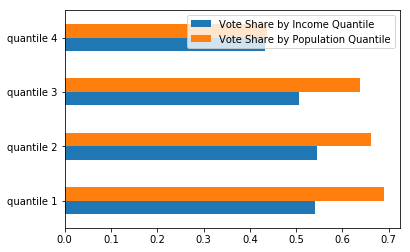

In [72]:
fig, ax = plt.subplots()

combo.plot(kind = "barh", ax = ax)

plt.show()